In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import fbeta_score, make_scorer, f1_score

import time

In [3]:
# read in data 
train_df = pd.read_csv('train.csv')

### Data Processing

In [4]:
# make attrition into boolean
train_df['label'] = [1 if x == 'Yes' else 0 for x in train_df['Attrition']]

#### Class Categories

In [212]:
# class balance 
train_df.groupby('Attrition').size()

Attrition
No     1181
Yes     159
dtype: int64

#### Numerical Data

In [5]:
# get all numerical data
all_num_data = train_df[['Age', 'DailyRate', 'DistanceFromHome', 
                         'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 
                         'NumCompaniesWorked','PercentSalaryHike',
                         'TotalWorkingYears', 'TrainingTimesLastYear', 
                         'YearsAtCompany', 'YearsInCurrentRole', 
                         'YearsSinceLastPromotion',
                         'YearsWithCurrManager']].copy()

In [6]:
# try making proportions of numeric data 
all_num_data['prop_at_company'] = all_num_data.loc[:, 'YearsAtCompany']/ 
    all_num_data.loc[:, 'TotalWorkingYears']
all_num_data['prop_in_role'] = all_num_data.loc[:,'YearsInCurrentRole'] / 
    all_num_data.loc[:,'YearsAtCompany']
all_num_data['prop_manager'] = all_num_data.loc[:,'YearsWithCurrManager'] / 
    all_num_data.loc[:,'YearsAtCompany']
all_num_data['starting_age'] = all_num_data.loc[:,'Age'] - 
    all_num_data.loc[:,'TotalWorkingYears']

In [ ]:
# t-test results 
# sig 
# Age
# DistanceFromHome
# MonthlyIncome
# TotalWorkingYears
# YearsAtCompany
# YearsInCurrentRole
# YearsSinceLastPromotion
# YearsWithCurrManager

# not really 
# DailyRate 0.04

# not sig
# HourlyRate
# MonthlyRate
# NumCompaniesWorked
# PercentSalaryHike
# TrainingTimesLastYear

In [168]:
# two sample t tests
ttest_ind(train_df.YearsWithCurrManager[train_df.label == 1] , 
          train_df.YearsWithCurrManager[train_df.label == 0], 
          equal_var=False)

Ttest_indResult(statistic=-9.447424555409121, pvalue=3.537021583242409e-18)

#### Categorical Data

In [117]:
# anova results 
# not sig 
# department
# education
# education field 
# Gender
# PerformanceRating
# RelationshipSatisfaction

# not really
# JobSatisfaction 0.04 but no pairwise sig
# WorkLifeBalance only a little bit  (1 vs not)

# sig
# business travel 
# EnvironmentSatisfaction
# JobInvolvement !
# JobLevel !
# JobRole !
# MaritalStatus
# OverTime !
# Shift!


In [143]:
# anova test 
model = ols('label ~ C(WorkLifeBalance)', data=train_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(WorkLifeBalance),2.136707,3.0,6.895423,0.000131
Residual,137.996875,1336.0,NaN,NaN


In [144]:
# pairwise step down t-tests 
sp.posthoc_ttest(train_df, val_col='label',group_col ='WorkLifeBalance', 
                 equal_var=False, p_adjust = 'holm')

,3,2,1,4
3,1.000000,0.214708,0.012222,0.597453
2,0.214708,1.000000,0.100920,0.801794
1,0.012222,0.100920,1.000000,0.100920
4,0.597453,0.801794,0.100920,1.000000


### EDA

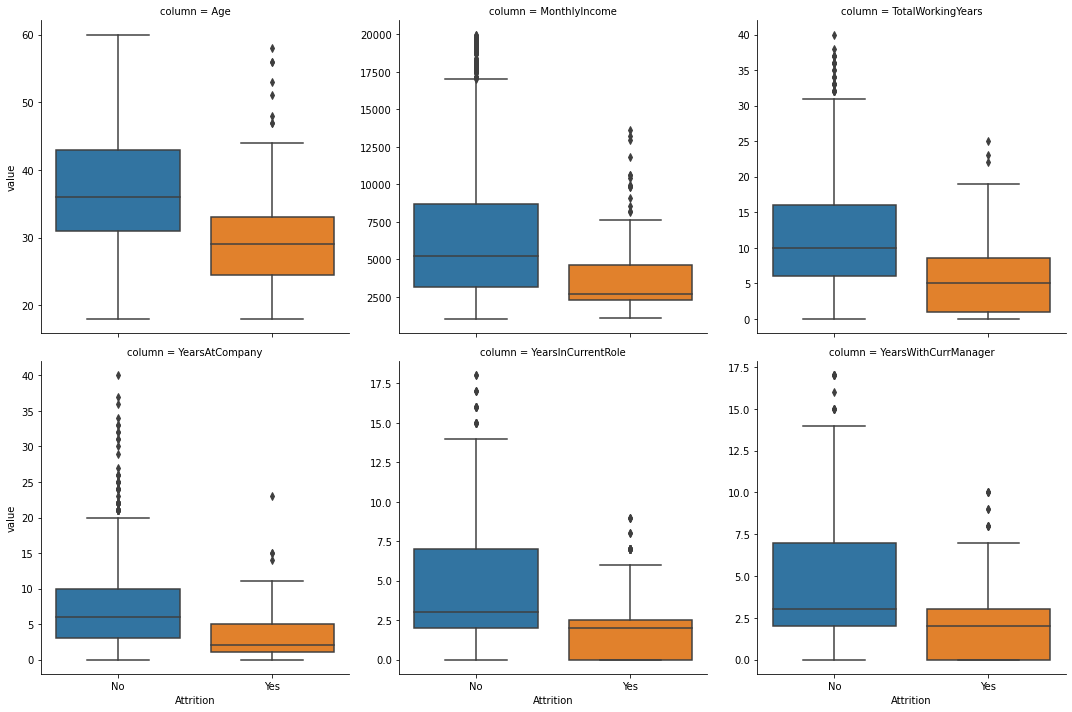

In [63]:
# numerical boxplot
# facetting numeric
num_melt_data = train_df[['Attrition', 'Age', 'MonthlyIncome', 
       'TotalWorkingYears', 
       'YearsAtCompany', 'YearsInCurrentRole', 
       'YearsWithCurrManager']].melt(id_vars = 'Attrition',
                                     var_name = 'column', 
                                     value_name = 'value')

sns.catplot(
    data=num_melt_data, x='Attrition', y='value',
    col='column', kind='box', col_wrap=3, sharey=False
)

<AxesSubplot:>

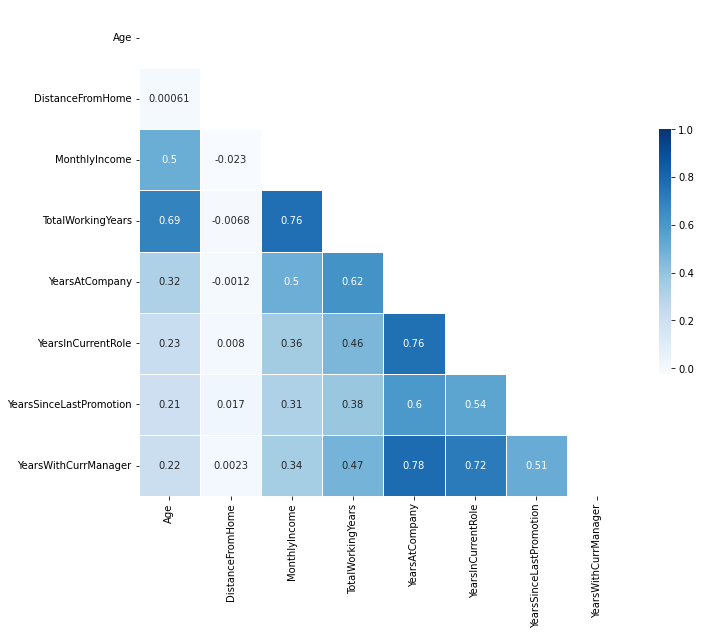

In [65]:
# correlation matrix for predictors 
# numeric significant predictors 
corr = train_df[['Age', 'DistanceFromHome', 'MonthlyIncome', 
       'TotalWorkingYears', 
       'YearsAtCompany', 'YearsInCurrentRole', 
             'YearsSinceLastPromotion',
       'YearsWithCurrManager']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("Blues", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0.5, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:xlabel='Job Involvement', ylabel='Proportion Attrition'>

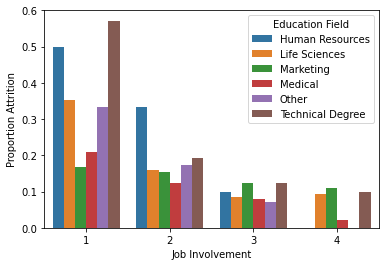

In [66]:
# categorical barplot
train_df.groupby(['EducationField', 'JobInvolvement']).agg(
    {'label':'mean'}).reset_index().rename(
    columns={'label':'Proportion Attrition', 
             'EducationField':'Education Field', 
             'JobInvolvement':'Job Involvement'}
).pipe((sns.barplot, "data"), x='Job Involvement', 
       y='Proportion Attrition', hue='Education Field')

In [6]:
# subset data based on feature selection
sig_num_data = train_df[['Age','DistanceFromHome','MonthlyIncome',
                         'TotalWorkingYears','YearsAtCompany',
                         'YearsInCurrentRole','YearsSinceLastPromotion',
                         'YearsWithCurrManager',]]
sig_cat_data = train_df[['BusinessTravel', 'EnvironmentSatisfaction', 
                         'JobInvolvement', 'JobLevel', 'MaritalStatus', 
                         'OverTime', 'Shift']]

# make dummies 
sig_dummy_data = pd.get_dummies(sig_cat_data)

# add specific dummy for work life balance 1 vs not
sig_dummy_data['WorkLifeBalance_1'] = [1 if x == 1 else 0 
                                       for x in train_df['WorkLifeBalance']]

In [7]:
# get all data, not just significant predictors 
cat_data = train_df[['BusinessTravel', 'Department', 'Education', 
                     'EducationField', 'EnvironmentSatisfaction', 
                     'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 
                     'JobSatisfaction', 'MaritalStatus', 'Over18', 
                     'OverTime', 'PerformanceRating','RelationshipSatisfaction', 
                     'Shift','WorkLifeBalance']].astype('category')
dummy_data = pd.get_dummies(cat_data)

num_data = train_df[['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 
                     'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
                     'PercentSalaryHike','TotalWorkingYears', 
                     'TrainingTimesLastYear', 'YearsAtCompany', 
                     'YearsInCurrentRole', 'YearsSinceLastPromotion',
                     'YearsWithCurrManager']]

In [8]:
# make train data on all 
train_df_2 = pd.concat([train_df.label, num_data, dummy_data], axis =1)
X2 = train_df_2.drop(columns=['label']).copy()
y2 = train_df_2.label.copy()

In [7]:
# make train data on sig
# train_df_sig = pd.concat([train_df.label, sig_num_data, sig_dummy_data], axis =1)

# X = train_df_sig.drop(columns=['label']).copy()
# y = train_df_sig.label.copy()

### Model Tuning 

In [129]:
# hyperparameter tuning 
def tuning(X_train, y_train):
    ''' takes a given X and y and tunes for smote & under 
    and smote & tomek,as well as random forest, gradient boosting, 
    and Adaboost models - returns the cv results and the model fit 
    for the best one of each models'''
    
    # create scores
    scoring = {"AUC": "roc_auc", 'F1': 'f1_weighted'}
    
    
    # create pipeline
    # smote and undersampling with 3 neighbors
    both3_pipe = imbPipeline([
        ('over', SMOTE(k_neighbors=3)), 
        ('under', RandomUnderSampler()),
        ('classifier', RandomForestClassifier()) 
    ])
    # smote and undersampling with 5 neighbors
    both5_pipe = imbPipeline([
        ('over', SMOTE(k_neighbors=5)), 
        ('under', RandomUnderSampler()),
        ('classifier', RandomForestClassifier()) 
    ])
    # smote w tomek links with 3 neighbors
    smt3_pipe = imbPipeline([
        ('resampling', SMOTETomek(smote= SMOTE(sampling_strategy='minority', 
                                               k_neighbors=3))),
        ('classifier' , RandomForestClassifier())])
    # smote w tomek links with 5 neighbors
    smt5_pipe = imbPipeline([
        ('resampling', SMOTETomek(smote= SMOTE(sampling_strategy='minority',
                                               k_neighbors=5))),
        ('classifier' , RandomForestClassifier())])
    
    # set params for steps of pipeline 
    param_grid = [
        {'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : list(range(25,251,25)),
        'classifier__max_features' : ['log2', 'sqrt'],
        'classifier__max_depth' : list(range(1, 6))},
        {'classifier' : [GradientBoostingClassifier()],
        'classifier__n_estimators' : list(range(25,251,25)),
        'classifier__max_features' : ['log2', 'sqrt'],
        'classifier__max_depth' : list(range(1, 6))},
        {'classifier' : [AdaBoostClassifier()],
        'classifier__n_estimators': list(range(10,51,10)),
         'classifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}
    ]

    # create folds for cv
    folds = RepeatedStratifiedKFold(n_repeats=5, random_state=512)
    
    # grid search through param grid
    both3_gscv = GridSearchCV(both3_pipe, param_grid = param_grid, 
                              cv = folds, verbose=0, scoring=scoring, 
                              refit='AUC',)
    smt3_gscv = GridSearchCV(smt3_pipe, param_grid = param_grid, 
                             cv = folds, verbose=0, scoring=scoring, 
                             refit='AUC',)
    both5_gscv = GridSearchCV(both5_pipe, param_grid = param_grid, 
                              cv = folds, verbose=0, scoring=scoring, 
                              refit='AUC',)
    smt5_gscv = GridSearchCV(smt5_pipe, param_grid = param_grid, 
                             cv = folds, verbose=0, scoring=scoring, 
                             refit='AUC',)
    

    # fit on data
    smt3_gscv.fit(X_train, y_train)
    both3_gscv.fit(X_train, y_train)
    print('finished k-3')
    
    smt5_gscv.fit(X_train, y_train)
    both5_gscv.fit(X_train, y_train)
    print('finished k-5')

    return [smt3_gscv, smt5_gscv, both3_gscv, both5_gscv]

In [12]:
# time training
start_train = time.time()
smt_res3_v3,smt_res5_v3, both_res3_v3, both_res5_v3 = tuning(X2, y2)
end_train = time.time()

finished k-3
finished k-5


In [13]:
# train time 
end_train-start_train

5310.188762664795

#### Find best hyperparameter & model

In [177]:
# getting cv results 
smt_res3_df = pd.DataFrame(smt_res3_v3.cv_results_)
smt_res5_df = pd.DataFrame(smt_res5_v3.cv_results_)
both_res3_df = pd.DataFrame(both_res3_v3.cv_results_)
both_res5_df = pd.DataFrame(both_res5_v3.cv_results_)

In [178]:
both_res3_df.mean_test_F1.max()

0.9342203904899563

In [179]:
both_res5_df.mean_test_F1.max()

0.9342462602807566

In [180]:
smt_res3_df.mean_test_F1.max()

0.9346943639144921

In [181]:
smt_res5_df.mean_test_F1.max()

0.9352922047035329

In [184]:
# finding params based on the model config that had highest mean F1 score 
list(smt_res5_df.params[smt_res5_df.mean_test_F1 == 
                        smt_res5_df.mean_test_F1.max()]) 

[{'classifier': GradientBoostingClassifier(max_depth=2, max_features='sqrt', n_estimators=250),
  'classifier__max_depth': 2,
  'classifier__max_features': 'log2',
  'classifier__n_estimators': 250}]

In [185]:
# fitting model based on above params - this is the classifier used to make predictions
t = imbPipeline([
        ('resampling', SMOTETomek(smote= SMOTE(sampling_strategy='minority', 
                                               k_neighbors=5))),
        ('classifier' , GradientBoostingClassifier(max_depth=2, 
                                                   max_features='log2', n_estimators=250))])
t.fit(X2, y2)

Pipeline(steps=[('resampling',
                 SMOTETomek(smote=SMOTE(sampling_strategy='minority'))),
                ('classifier',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
                                            n_estimators=250))])

#### Table on training results

In [202]:
# find best F1 / AUC of each model for each sampling method 

# get results, and make classifier column into string 
both_res5_df['classifier_str'] = both_res5_df1.param_classifier.astype('str')
both_res3_df['classifier_str'] = both_res3_df1.param_classifier.astype('str')
smt_res5_df['classifier_str'] = smt_res5_df1.param_classifier.astype('str')
smt_res3_df['classifier_str'] = smt_res3_df1.param_classifier.astype('str')

smt3_gb = smt_res3_df[smt_res3_df.classifier_str
                      .str.contains('Gradient')].copy()
smt3_gb['params_str'] = smt3_gb.params.astype('str')

smt5_gb = smt_res5_df[smt_res5_df.classifier_str
                      .str.contains('Gradient')].copy()
smt5_gb['params_str'] = smt5_gb.params.astype('str')

both3_gb = both_res3_df[both_res3_df.classifier_str
                        .str.contains('Gradient')].copy()
both3_gb['params_str'] = both3_gb.params.astype('str')

both5_gb = both_res5_df[both_res5_df.classifier_str
                        .str.contains('Gradient')].copy()
both5_gb['params_str'] = both5_gb.params.astype('str')

In [195]:
# find max F1 for sampling type and rf
print(smt_res5_df1[smt_res5_df1.classifier_str
                   .str.contains('Forest')]['mean_test_F1'].max())
# find max AUC for sampling type and rf
print(smt_res5_df1[smt_res5_df1.classifier_str
                   .str.contains('Forest')]['mean_test_AUC'].max())

0.9144308019945826
0.925142211135411


In [196]:
# find max F1 for sampling type and gb
print(smt_res5_df1[smt_res5_df1.classifier_str
                   .str.contains('Gradient')]['mean_test_F1'].max())
# find max AUC for sampling type and gb
print(smt_res5_df1[smt_res5_df1.classifier_str
                   .str.contains('Gradient')]['mean_test_AUC'].max())

0.9352922047035329
0.9524377873593051


In [197]:
# find max F1 for sampling type and ab
print(smt_res5_df1[smt_res5_df1.classifier_str
                   .str.contains('AdaBoost')]['mean_test_F1'].max())
# find max AUC for sampling type and ab
print(smt_res5_df1[smt_res5_df1.classifier_str
                   .str.contains('AdaBoost')]['mean_test_AUC'].max())

0.9229145433912884
0.9321965518901985


#### Density plot of mean f1 scores by model

In [198]:
# concat all res together
res_total = pd.concat([smt_res3_df, smt_res5_df,
                       both_res3_df, both_res5_df], axis=0)
res_total.reset_index(inplace=True)

In [199]:
conditions = [
    res_total.classifier_str.str.contains('RandomForest'),
    res_total.classifier_str.str.contains('Gradient')]
choices = ['Random Forest', 'Gradient Boosting']
res_total['classifier'] = np.select(conditions, choices, default='AdaBoost')

Text(0.5, 0, 'Mean F1 Score')

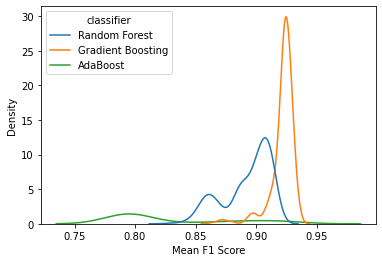

In [200]:
sns.kdeplot(data=res_total, x='mean_test_F1', hue='classifier')
plt.xlabel('Mean F1 Score')

#### Plot on hyperparameter GB training

**for max depth**

In [203]:
depth_res_list = []

# smt3
for i in range(1,6):
    string=': ' + str(i)
    depth_res_list.append({'sampling_method':'smote_tomek_3', 
                           'max_depth':i, 
                  'F1':smt3_gb[smt3_gb.params_str.str.contains(string)]
                           .mean_test_F1.mean()})
    
    depth_res_list.append({'sampling_method':'smote_tomek_5', 
                           'max_depth':i, 
                  'F1':smt5_gb[smt5_gb.params_str.str.contains(string)]
                           .mean_test_F1.mean()})
    
    depth_res_list.append({'sampling_method':'smote_under_3', 
                           'max_depth':i, 
                  'F1':both3_gb[both3_gb.params_str.str.contains(string)]
                           .mean_test_F1.mean()})

    
    depth_res_list.append({'sampling_method':'smote_under_5', 'max_depth':i, 
                  'F1':both5_gb[both5_gb.params_str.str.contains(string)]
                           .mean_test_F1.mean()})

In [204]:
depth_res = pd.DataFrame(depth_res_list)

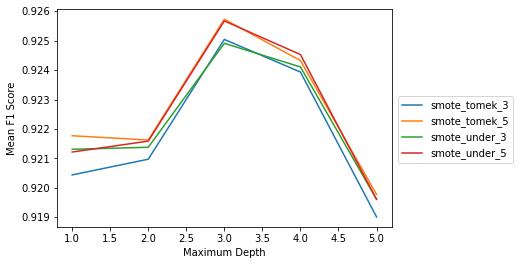

In [205]:
sns.lineplot(data=depth_res, x = 'max_depth', y='F1', hue='sampling_method')
plt.xlabel("Maximum Depth")
plt.ylabel("Mean F1 Score")
plt.legend(bbox_to_anchor=(1.02, 0.6), loc='upper left', borderaxespad=0)

**for max features**

In [206]:
feat_res_list = []

# smt3
for i in ['log', 'sqrt']:
    feat_res_list.append({'sampling_method':'smote_tomek_3', 
                          'max_feat':i, 
                  'F1':smt3_gb[smt3_gb.params_str.str.contains(i)]
                          .mean_test_F1.mean()})
    
    feat_res_list.append({'sampling_method':'smote_tomek_5', 
                          'max_feat':i, 
                  'F1':smt5_gb[smt5_gb.params_str.str.contains(i)]
                          .mean_test_F1.mean()})
    
    feat_res_list.append({'sampling_method':'smote_under_3', 
                          'max_feat':i, 
                  'F1':both3_gb[both3_gb.params_str.str.contains(i)]
                          .mean_test_F1.mean()})

    feat_res_list.append({'sampling_method':'smote_under_5', 
                          'max_feat':i, 
                  'F1':both5_gb[both5_gb.params_str.str.contains(i)]
                          .mean_test_F1.mean()})

In [207]:
feat_res = pd.DataFrame(feat_res_list)

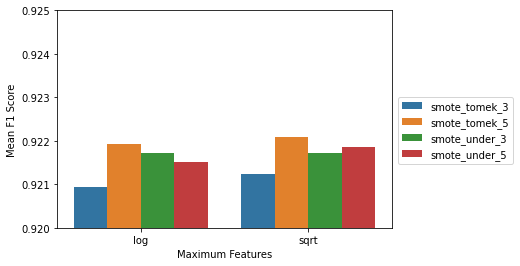

In [208]:
sns.barplot(data=feat_res, x = 'max_feat', y='F1', hue='sampling_method')
plt.xlabel("Maximum Features")
plt.ylabel("Mean F1 Score")
plt.ylim(0.92, 0.925)
plt.legend(bbox_to_anchor=(1.35, 0.5), loc='center right', borderaxespad=0)
plt.legend(bbox_to_anchor=(1.02, 0.6), loc='upper left', borderaxespad=0)

**For num features** 

In [209]:
n_est_list = []

# smt3
for i in range(25, 251, 25):
    string=': ' + str(i)
    n_est_list.append({'sampling_method':'smote_tomek_3', 
                       'n_estimators':i, 
                  'F1':smt3_gb[smt3_gb.params_str.str.contains(string)]
                       .mean_test_F1.mean()})
    
    n_est_list.append({'sampling_method':'smote_tomek_5', 
                       'n_estimators':i, 
                  'F1':smt5_gb[smt5_gb.params_str.str.contains(string)]
                       .mean_test_F1.mean()})
    
    n_est_list.append({'sampling_method':'smote_under_3', 
                       'n_estimators':i, 
                  'F1':both3_gb[both3_gb.params_str.str.contains(string)]
                       .mean_test_F1.mean()})

    n_est_list.append({'sampling_method':'smote_under_5', 
                       'n_estimators':i, 
                  'F1':both5_gb[both5_gb.params_str.str.contains(string)]
                       .mean_test_F1.mean()})

In [210]:
n_est_res = pd.DataFrame(n_est_list)

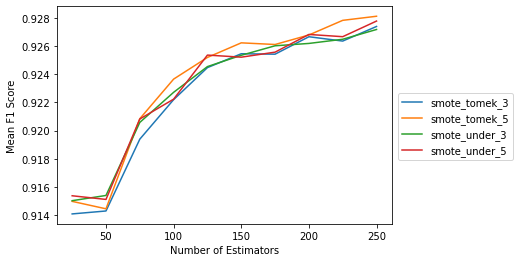

In [211]:
sns.lineplot(data=n_est_res, x = 'n_estimators', y='F1', hue='sampling_method')
plt.xlabel("Number of Estimators")
plt.ylabel("Mean F1 Score")
plt.legend(bbox_to_anchor=(1.02, 0.6), loc='upper left', borderaxespad=0)

#### Feature importance plot on GB best on training

### Make Predictions

In [21]:
# read test data
test_df = pd.read_csv('test.csv')

In [22]:
# process data
cat_test_data = test_df[['BusinessTravel', 'Department', 'Education', 
                         'EducationField', 'EnvironmentSatisfaction', 
                         'Gender', 'JobInvolvement', 'JobLevel', 
                         'JobRole', 'JobSatisfaction', 'MaritalStatus', 
                         'Over18', 'OverTime', 'PerformanceRating',
                         'RelationshipSatisfaction', 'Shift',
                         'WorkLifeBalance']].astype('category')
dummy_test_data = pd.get_dummies(cat_test_data)

num_test_data = test_df[['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 
                         'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
                         'PercentSalaryHike','TotalWorkingYears', 
                         'TrainingTimesLastYear', 'YearsAtCompany', 
                         'YearsInCurrentRole', 'YearsSinceLastPromotion',
                         'YearsWithCurrManager']]

In [23]:
# concat data together
X_test = pd.concat([num_test_data,dummy_test_data], axis =1)

In [192]:
# make predictors and make format consistent
test_preds = t.predict(X_test)
test_preds_df = pd.DataFrame({'id':range(len(test_preds)), 
                              'Predicted':test_preds})

In [193]:
# test_preds_df.to_csv('test_preds_33.csv', index=False)